# 데이터 준비

In [33]:
import warnings
warnings.filterwarnings('ignore')

## Confounds 불러오기

In [1]:
# confounds 불러오기
import pandas as pd
from nilearn import image

'''
'2207071', '2207141', '2207142', '2207143', '2207271', '2207272', '2207273',
          '2208041', '2208042', '2208043', '2208231', '2208232', '2208233', '2209022',
          '2209023', '2209222', '2209223', '2303101', '2303102', '2303103', '2303131',
          '2303132', '2303133', '2303161', '2303162', '2303163', '2303201', '2303202', '2303203'
'''

con_path = 'D:/fmri/3. derivatives 폴더에 넣어야 하는 것 (전처리 후 데이터, MNI 템플릿)/fmriprep/sub-ID{}/func/sub-ID{}_task-r1_desc-confounds_timeseries.tsv'
sub_ids = ['2207143', '2207271', '2207272', '2207273',
          '2208041', '2208042', '2208043', '2208231', '2208232', '2208233',]

con_list = []

for sub_id in sub_ids:
    file_path = con_path.format(sub_id, sub_id)
    con = pd.read_csv(file_path, sep='\t')

    con1 = con.fillna(0)

    con_list.append(pd.DataFrame(con1))
    

In [2]:
len(con_list)

10

## 참가자 bold 데이터 불러오기

In [3]:
import os

# 경로, 참가자들 리스트
# 노트북 메모리 딸려서 조금만 가져오기
'''
'2207071', '2207141', '2207142', '2207143', '2207271', '2207272', '2207273',
          '2208041', '2208042', '2208043', '2208231', '2208232', '2208233', '2209022',
          '2209023', '2209222', '2209223', '2303101', '2303102', '2303103', '2303131',
          '2303132', '2303133', '2303161', '2303162', '2303163', '2303201', '2303202', '2303203'
'''

base_path = 'D:/fmri/3. derivatives 폴더에 넣어야 하는 것 (전처리 후 데이터, MNI 템플릿)/fmriprep/sub-ID{}/func/sub-ID{}_task-r1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'

In [4]:
func_list = []

for sub_id in sub_ids:
    file_path = base_path.format(sub_id, sub_id)
    data = image.load_img(file_path)
    
    func_list.append(data)

In [5]:
func_list

## 참가자 데이터 전처리

In [80]:
func_dc_list = []

try:
    for i in range(len(func_list)):
        func_dc = image.clean_img(func_list[i], detrend=True, standardize=False, t_r=2,
                              confounds=con_list[i])
        func_dc_list.append(func_dc)

except:
    print("error file :", con_list[i])
    

In [81]:
func_dc_list

## Feature 준비

In [82]:
# 합치기
all_func = image.concat_imgs(func_dc_list)
all_func.shape

(65, 77, 65, 2750)

In [83]:
img_mean = image.mean_img(all_func)
img_mean.shape

(65, 77, 65)

## 마스크 생성해서 복셀값 가져오기

In [38]:
t1 = image.load_img('D:/fmri/3. derivatives 폴더에 넣어야 하는 것 (전처리 후 데이터, MNI 템플릿)/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-02_desc-brain_T1w.nii.gz')
# t1 이미지 해상도
t1.shape

(96, 114, 96)

In [84]:
# resample
img_resampled = image.resample_to_img(t1, all_func)
img_resampled.shape

(65, 77, 65)

In [85]:
from scipy.ndimage import binary_dilation
import nibabel as nb
import numpy as np

# 데이터를 200이상인 값은 1로, 그외의 값 0으로 변환. # 값은 계속 돌려가며 한번 보자.
data_binary = np.array(img_resampled.get_fdata()>=220, dtype=np.int8)

# Dilate binary mask once
# 이진화된 데이터 팽창작엄.(마스크 확장해서 뇌영상 데이터에서 원하는 복셀 더 포함)
# data_dialted = binary_dilation(data_binary, iterations=1).astype(np.int8)

# Save binary mask in NIfTI image
# img_mask = nb.Nifti1Image(data_dialted, img_resampled.affine, img_resampled.header)
brain_mask = nb.Nifti1Image(data_binary, img_resampled.affine, img_resampled.header)
brain_mask.set_data_dtype('i1')

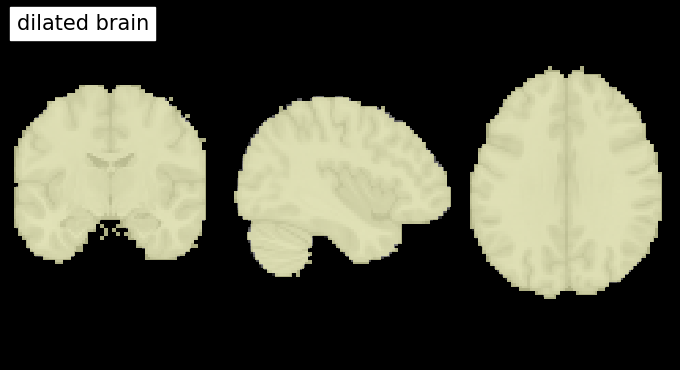

In [86]:
from nilearn.plotting import plot_roi
plot_roi(brain_mask, draw_cross=False, annotate=False, black_bg=True,
        bg_img=t1, cut_coords=[40,-10,30], title='dilated brain', cmap='magma_r', dim=1)

In [87]:
from nilearn import masking

X = masking.apply_mask(all_func, brain_mask)
print("Shape of indexed data:", X.shape)

Shape of indexed data: (2750, 72978)


## onset 불러와 합치기

In [88]:
import numpy as np

onset_path = 'D:/fmri/3. derivatives 폴더에 넣어야 하는 것 (전처리 후 데이터, MNI 템플릿)/fmriprep/sub-ID{}/eve_files/sub-ID{}_task-r1_events.tsv'

from scipy.interpolate import interp1d

onset_list = []

for sub_id in sub_ids:
    file_path = onset_path.format(sub_id, sub_id)
    onset_file = pd.read_csv(file_path, sep='\t')

    events = onset_file['stim_onset'].values
    predictor_all = np.zeros(550, dtype=int)

    
    for i in [4,5,6]:
        events1 = events.astype(int) + i
        predictor_all[events1.astype(int)] = 1
    
#    for i in range(4):
#         events1 = events.astype(int) + i
#         predictor_all[events1.astype(int)] = 1

    original_scale = np.arange(0, 550, 1) # 0~550 초
    resampler = interp1d(original_scale, predictor_all)

    desired_scale = np.arange(0, 550, 2)
    y = resampler(desired_scale)

    onset_list.append(y)

In [89]:
onset_list

[array([0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
        1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0.,
        1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0.,
        0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1.,
        1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0.,
        1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0.,
        0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0.,
        0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1.,
        1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0.,
        1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0.,
        0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0.,
        0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1.,
        1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1.,
        1., 

In [73]:
len(onset_list)

10

In [90]:
onset_y = np.concatenate(onset_list)
y = onset_y.ravel()
y.shape

(2750,)

## 참가자별 chunks 만들기

In [19]:
chunks = np.ravel([[i] * 275 for i in range(len(func_dc_list))])
len(chunks)

2750

In [20]:
np.unique(chunks)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# SVC 해보기

In [21]:
# vis ROI linear SVC
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from bayes_opt import BayesianOptimization
from hyperopt import hp
from sklearn.metrics import roc_auc_score, make_scorer, accuracy_score
from sklearn.model_selection import cross_val_score

In [91]:
# train : test = 5:5
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, c_train, c_test = train_test_split(
    X, y, chunks, test_size =0.4, random_state=42, shuffle=False)

In [92]:
print('Shapes of X:', X_train.shape, X_test.shape)
print('Shapes of y:', y_train.shape, y_test.shape)

Shapes of X: (1650, 72978) (1100, 72978)
Shapes of y: (1650,) (1100,)


In [93]:
# 파라미터

C_para = {'C': (0.001, 30)}

# 목적함수 지정

def svc_cv(C):
    model = LinearSVC(penalty = 'l2',
                     loss = 'squared_hinge',
                     max_iter = 1000,
                     C = C)
    result = cross_val_score(model, X_train, y_train, groups=c_train, cv =5)
    acc_score = result.mean()
    return acc_score

In [94]:
bayes_svc = BayesianOptimization(svc_cv, pbounds = C_para, verbose=2, random_state =42)
# bayes_svc.set_gp_params(alpha = 1e-3)
bayes_svc.maximize(init_points = 4, n_iter = 25)

|   iter    |  target   |     C     |
-------------------------------------
| 1         | 0.4927    | 11.24     |
| 2         | 0.4855    | 28.52     |
| 3         | 0.4836    | 21.96     |
| 4         | 0.5079    | 17.96     |
| 5         | 0.4945    | 17.91     |
| 6         | 0.4933    | 17.96     |
| 7         | 0.4873    | 17.96     |
| 8         | 0.5218    | 8.992     |
| 9         | 0.5036    | 5.458     |
| 10        | 0.5036    | 21.72     |
| 11        | 0.5       | 1.72      |
| 12        | 0.5036    | 20.86     |
| 13        | 0.5133    | 21.72     |
| 14        | 0.5012    | 19.58     |
| 15        | 0.5055    | 10.76     |
| 16        | 0.5067    | 22.71     |
| 17        | 0.4915    | 6.91      |
| 18        | 0.5206    | 21.72     |
| 19        | 0.4958    | 21.72     |
| 20        | 0.4964    | 21.02     |
| 21        | 0.5061    | 15.52     |
| 22        | 0.4885    | 10.76     |
| 23        | 0.4964    | 19.58     |
| 24        | 0.4952    | 7.546     |
| 25        

In [79]:
# 표준화 o, 4~6초 peak을 보았을 때 : {'target': 0.49393939393939396, 'params': {'C': 27.662999296798002}}

bayes_svc.max

{'target': 0.49393939393939396, 'params': {'C': 27.662999296798002}}

In [ ]:
# 표준화 x, 6초 이후 peak만 보았을 때 : {'target': 0.6242424242424243, 'params': {'C': 7.180883841482059}}

In [52]:
svc = LinearSVC(penalty = 'l2',
                     loss = 'squared_hinge',
                     max_iter = 500,
                     C = 7.180)

In [54]:
svc.fit(X_train, y_train)

LinearSVC(C=7.18, max_iter=500)

In [29]:
'''
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', LinearSVC(penalty = 'l2',
                     loss = 'squared_hinge',
                     max_iter = 500,
                     C = 0.570)))                   
])

from sklearn.model_selection import KFold

kf = KFold(n_splits=5)

grid_cv_v1 = GridSearchCV(pipe, grid, cv=kf,
                          return_train_score=True, refit=True, n_jobs=3, verbose=1)

grid_cv_v1.fit(X=X_train, y=y_train, groups=c_train)                          
'''

In [58]:
pred = svc.predict(X_test)

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

confusion = confusion_matrix(y_test, pred)
accuracy = accuracy_score(y_test, pred)
recall = recall_score(y_test, pred)
precision = precision_score(y_test, pred)

print('혼동행렬 : \n',
      confusion)
print(f"정확도 : {accuracy:.4f}, 민감도 : {recall:.4f}, 정밀도 : {precision:.4f}")

혼동행렬 : 
 [[483 377]
 [137 103]]
정확도 : 0.5327, 민감도 : 0.4292, 정밀도 : 0.2146


In [60]:
# C = 0.1 일 때 가장 좋음.
grid_cv_v1.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('svc', LinearSVC(C=0.1, max_iter=500))])

# ROI로 해보기(+ ROI 별 평균으로 분석도 가능)

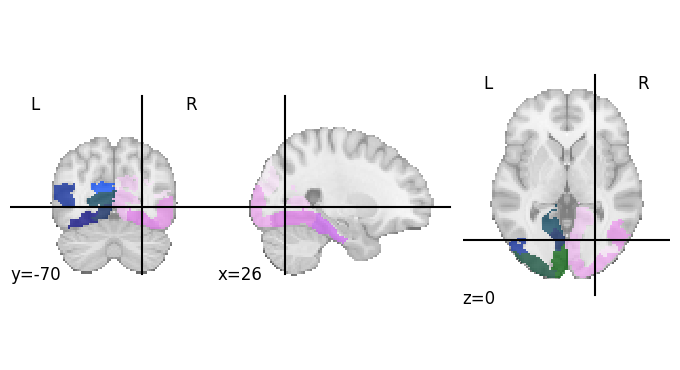

In [61]:
# atlas 가져오기
from nilearn.datasets import fetch_atlas_schaefer_2018
# 관심 roi 100구역, 공간 해상도 2mm
schaefer_parc = fetch_atlas_schaefer_2018(n_rois=100, resolution_mm=2, verbose=False)

atlas_label = schaefer_parc['labels']

img_atlas = image.load_img(schaefer_parc['maps'])

idx_vis = [1,2,3,4,5,6,7,8,9,51,52,53,54,55,56,57,58]

roi_ints = img_atlas.get_fdata()

roi_ints[~np.isin(roi_ints, idx_vis)] = 0
new_img = image.new_img_like(img_atlas, roi_ints)
plot_roi(new_img)

In [62]:
new_img.shape

(91, 109, 91)

In [63]:
# 0보다 큰 영역 선택
img_roi = image.math_img("img>0", img=new_img)

# resample
img_resampled = image.resample_to_img(img_roi, img_mean, interpolation='nearest')

# 마스크
mask_vis = image.math_img("((mean != 0)*img)>0.5", mean=img_mean, img = img_resampled)
mask_vis.shape

(65, 77, 65)

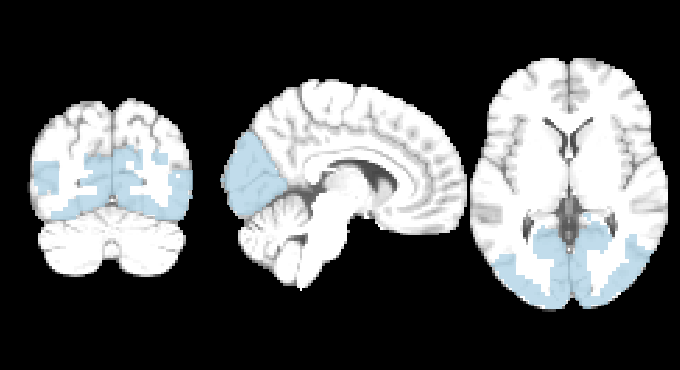

In [64]:
# Plotting Vis mask
plot_roi(mask_vis, t1, cmap='Paired', dim=-.5, draw_cross=False, annotate=False);

In [65]:
# Mask ML dataset with Visual ROI mask
from nilearn.maskers import NiftiMasker
masker_vis = NiftiMasker(mask_img=mask_vis, standardize=False, detrend=False,
                     memory="nilearn_cache", memory_level=2)
X_roi = masker_vis.fit_transform(all_func)
print("Shape of indexed data:", X_roi.shape)

Shape of indexed data: (5500, 6713)


In [66]:
X_roi

array([[ 8.5950802e-11,  3.8248515e-11, -7.5708328e-11, ...,
         1.6739499e-11,  3.4944492e-11, -1.7985613e-11],
       [ 8.5666585e-11,  3.8127279e-11, -7.5465856e-11, ...,
         1.6699531e-11,  3.4853898e-11, -1.7941870e-11],
       [ 8.5400131e-11,  3.7991832e-11, -7.5210060e-11, ...,
         1.6634694e-11,  3.4733105e-11, -1.7877255e-11],
       ...,
       [ 2.9693079e+00, -1.3424060e-01, -2.6578858e+00, ...,
        -3.7393746e+00, -3.7081676e+00,  1.5025499e+00],
       [-7.3850346e-01,  2.5868740e+00,  2.5614779e+00, ...,
        -6.0203576e-01,  1.0111041e+00, -6.0712777e-02],
       [-1.0815854e+00,  5.0222337e-01,  2.3492069e+00, ...,
        -3.7087154e+00, -4.3952031e+00, -7.3410201e-01]], dtype=float32)

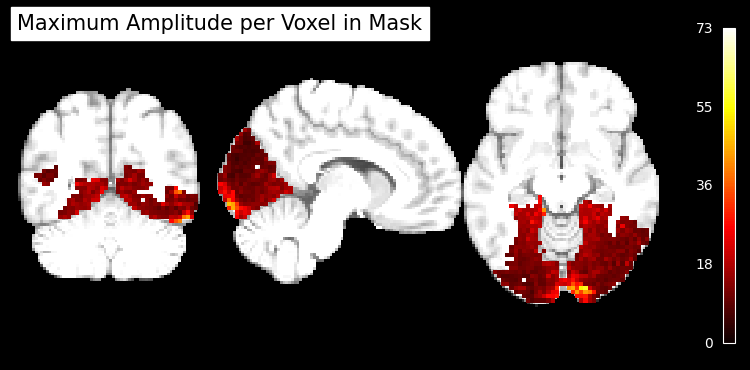

In [67]:
# unmasking 하기 x,y,z 형식으로 다시 만들기
from nilearn import plotting

masked_epi = masker_vis.inverse_transform(X_roi)
max_zscores = image.math_img("np.abs(img).max(axis=3)", img=masked_epi)
plotting.plot_stat_map(max_zscores, bg_img=t1, dim=-.5,
              draw_cross=False, annotate=False, colorbar=True,
              title='Maximum Amplitude per Voxel in Mask')

In [68]:
# train : test = 5:5
from sklearn.model_selection import train_test_split

X_train_roi, X_test_roi, y_train_roi, y_test_roi, c_train_roi, c_test_roi = train_test_split(
    X_roi, y, chunks, test_size =0.5, random_state=42, shuffle=False)

print('Shapes of X:', X_train_roi.shape, X_test_roi.shape)
print('Shapes of y:', y_train_roi.shape, y_test_roi.shape)

Shapes of X: (2750, 6713) (2750, 6713)
Shapes of y: (2750,) (2750,)


In [70]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', LinearSVC(penalty='l2',
                      loss='squared_hinge', max_iter=500))
])

grid_roi = {
    'svc__C' : [0.01, 0.1, 1, 10]
}

grid_cv_roi = GridSearchCV(pipe, grid_roi, cv=kf,
                          return_train_score=True, refit=True, n_jobs=4, verbose=1)

grid_cv_roi.fit(X=X_train_roi, y=y_train_roi, groups=c_train_roi)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svc', LinearSVC(max_iter=500))]),
             n_jobs=4, param_grid={'svc__C': [0.01, 0.1, 1, 10]},
             return_train_score=True, verbose=1)

In [72]:
# 0.01일 때 베스트
best_roi = grid_cv_roi.best_estimator_
best_roi

Pipeline(steps=[('scaler', StandardScaler()),
                ('svc', LinearSVC(C=0.01, max_iter=500))])

In [73]:
pred_roi = best_roi.predict(X_test_roi)

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

confusion_roi = confusion_matrix(y_test_roi, pred_roi)
accuracy_roi = accuracy_score(y_test_roi, pred_roi)
recall_roi = recall_score(y_test_roi, pred_roi)
precision_roi = precision_score(y_test_roi, pred_roi)

print('혼동행렬 : \n',
      confusion_roi)
print(f"정확도 : {accuracy_roi:.4f}, 민감도 : {recall_roi:.4f}, 정밀도 : {precision_roi:.4f}")

혼동행렬 : 
 [[1399  151]
 [1034  166]]
정확도 : 0.5691, 민감도 : 0.1383, 정밀도 : 0.5237


# PCA로 해보기

In [75]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1000)

print('Shape before pca:', X.shape)
pca.fit(X)
X_pca = pca.transform(X)
print('Shape after pca:', X_pca.shape)

Shape before pca: (5500, 73096)
Shape after pca: (5500, 1000)


In [76]:
# train : test = 5:5
from sklearn.model_selection import train_test_split

X_train_pca, X_test_pca, y_train_pca, y_test_pca, c_train_pca, c_test_pca = train_test_split(
    X_pca, y, chunks, test_size =0.5, random_state=42, shuffle=False)

print('Shapes of X:', X_train_pca.shape, X_test_pca.shape)
print('Shapes of y:', y_train_pca.shape, y_test_pca.shape)

Shapes of X: (2750, 1000) (2750, 1000)
Shapes of y: (2750,) (2750,)


In [78]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', LinearSVC(penalty='l2',
                      loss='squared_hinge', max_iter=500))
])

grid_pca = {
    'svc__C' : [0.01, 0.1, 1, 10]
}

grid_cv_pca = GridSearchCV(pipe, grid_pca, cv=kf,
                          return_train_score=True, refit=True, n_jobs=4, verbose=1)

grid_cv_pca.fit(X=X_train_pca, y=y_train_pca, groups=c_train_pca)

best_pca = grid_cv_pca.best_estimator_

pred_pca = best_pca.predict(X_test_pca)

confusion_pca = confusion_matrix(y_test_pca, pred_pca)
accuracy_pca = accuracy_score(y_test_pca, pred_pca)
recall_pca = recall_score(y_test_pca, pred_pca)
precision_pca = precision_score(y_test_pca, pred_pca)

print('혼동행렬 : \n',
      confusion_pca)
print(f"정확도 : {accuracy_pca:.4f}, 민감도 : {recall_pca:.4f}, 정밀도 : {precision_pca:.4f}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


혼동행렬 : 
 [[850 700]
 [637 563]]
정확도 : 0.5138, 민감도 : 0.4692, 정밀도 : 0.4458


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


# Searchlight 분석

In [79]:
from nilearn.decoding import SearchLight

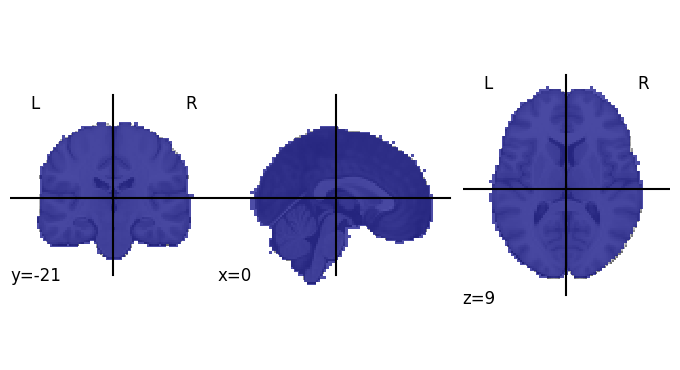

In [80]:
# 사용할 마스크

plotting.plot_roi(brain_mask)

In [81]:
# 내 CPU

import os
os.cpu_count()

8

In [86]:
# 서치 라이트
# 파이프 라인 만들기
# StandardScaler()도 넣어야하는데 우선은 빼고 해보자
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline

search_cv = KFold(n_splits=5, shuffle=True, random_state=42)
search_est = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', LinearSVC(penalty='l2', C = 0.1,
                      loss='squared_hinge', max_iter=500))
])

sl = SearchLight(
    mask_img=brain_mask,
    process_mask_img=brain_mask,
    radius=8,  # we'll use a 5 mm radius
    estimator=search_est,
    n_jobs=4,  # use only 1 core (for your own analyses, you might want to increase this!)
    scoring='accuracy',  # use accuracy as model performance metric
    cv=search_cv,
    verbose=True  # print a progressbar while fitting
)

In [85]:
print("Shape X:", all_func.shape)
print("Shape y:", y.shape)

Shape X: (65, 77, 65, 5500)
Shape y: (5500,)


In [87]:
sl.fit(all_func, y)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed: 826.9min remaining: 826.9min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed: 844.0min finished


SearchLight(cv=KFold(n_splits=5, random_state=42, shuffle=True),
            estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                      ('svc', LinearSVC(C=0.1, max_iter=500))]),
            mask_img=<nibabel.nifti1.Nifti1Image object at 0x000001A681152810>,
            n_jobs=4,
            process_mask_img=<nibabel.nifti1.Nifti1Image object at 0x000001A681152810>,
            radius=8, scoring='accuracy', verbose=True)

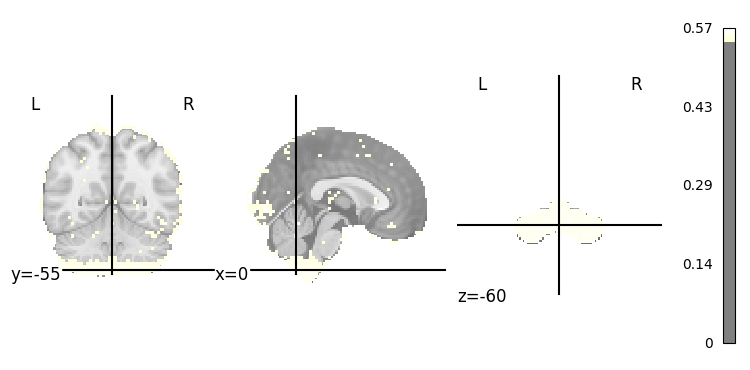

In [89]:
# 정확도 임계값 넘는 거만 한번 보자.
score_img = image.new_img_like(brain_mask, sl.scores_)
plotting.plot_stat_map(score_img, threshold=0.55)

In [51]:
# 좌표 추출
above_threshold_coords = np.argwhere(sl.scores_ >= 0.56)
above_threshold_coords

array([[ 8, 30, 25],
       [ 8, 30, 26],
       [ 8, 31, 24],
       ...,
       [57, 33, 23],
       [57, 37, 30],
       [57, 40, 22]], dtype=int64)

In [52]:
pred_sl = sl.predict(all_func)

confusion_sl = confusion_matrix(y_test_sl, pred_sl)
accuracy_sl = accuracy_score(y_test_sl, pred_sl)
recall_sl = recall_score(y_test_sl, pred_sl)
precision_sl = precision_score(y_test_sl, pred_sl)

print('혼동행렬 : \n',
      confusion_sl)
print(f"정확도 : {accuracy_sl:.4f}, 민감도 : {recall_sl:.4f}, 정밀도 : {precision_sl:.4f}")

AttributeError: 'SearchLight' object has no attribute 'predict'

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ('prerocessor', StandardScaler()),
    ('model', clf)
])

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, X, y, cv=kfold, scoring='accuracy')

In [ ]:
cv_scores